In [1]:
# Imports
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import uproot
import particle

# Imports from this project
sys.path.insert(0, "..")
from utils import paths
from utils.input_output import load_data_from_root, load_feature_keys, load_feature_properties
from utils.histograms import find_good_binning, get_hist, calc_pull
from utils.merge_pdfs import merge_pdfs


In [2]:
# Constant variables
input_files = [paths.B2JpsiKstar_file, paths.Bs2DsPi_file]

input_file_keys = ["DecayTree", "Bs2DspiDetached/DecayTree"]


In [3]:
def load_and_merge_from_root(input_files, input_file_keys, features_to_load, N_events_max_per_dataset=np.Infinity, same_N_events_forced=True):
    if same_N_events_forced:
        N_events = []
        for i, (input_file_path, input_file_key) in enumerate(zip(input_files, input_file_keys)):
            with uproot.open(input_file_path)[input_file_key] as tree:
                N_events.append(tree.num_entries)

        N_events_per_dataset = np.min(N_events + [N_events_max_per_dataset])
    else:
        N_events_per_dataset = N_events_max_per_dataset
    
    
    # concatenate all DataFrames into one
    df = pd.DataFrame()
    # iterate over all input files
    for i, (input_file_path, input_file_key) in enumerate(tqdm(zip(input_files, input_file_keys), total=len(input_files), desc="Datasets")):
        print(N_events_per_dataset)
        temp_df = load_data_from_root(input_file_path, 
                                    tree_key=input_file_key,
                                    features=features_to_load, 
                                    N_entries_max=np.Infinity, 
                                    batch_size=50000)
        
        temp_df.rename_axis(index={"entry":"event_id", "subentry": "track_id"},  inplace=True)

        temp_df["input_file_id"] = i

        if "B2JpsiKstar" in str(input_file_path):
            temp_df["decay_id"] = 0
        elif "Bs2DsPi" in str(input_file_path):
            temp_df["decay_id"] = 1
        else:
            raise NameError(f"Decay channel not recognized in Dataset {i}")

        # make sure all event ids are unambiguous
        if not df.empty:
            temp_df.reset_index(inplace=True)
            temp_df["event_id"] += df.index.max()[0] + 1
            temp_df.set_index(["event_id", "track_id"], inplace=True)
        
        # shuffle the events before shrinking the dataset (to adjust for imbalances)
        temp_event_ids = temp_df.index.unique("event_id")
        temp_event_ids = np.random.permutation(temp_event_ids)
        if N_events_per_dataset == np.Infinity:
            temp_df = temp_df.loc[temp_event_ids[:]]
        else:
            temp_df = temp_df.loc[temp_event_ids[:int(N_events_per_dataset)]]

        # append this batch to the DataFrame
        df = pd.concat([df, temp_df])
        
    return df

# Polarity

In [4]:
with uproot.open(paths.B2JpsiKstar_file)["DecayTree"] as tree:
    tree.keys()

In [8]:
features_to_load = ["Tr_T_x", "Tr_T_y", "Tr_T_Charge", "Polarity"]

df = load_and_merge_from_root(input_files, input_file_keys, features_to_load, 1000000000)

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Entries in the data: 215860
Entries to be loaded: 215860


Load Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Entries in the data: 1199342
Entries to be loaded: 215860


Load Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [17]:
df

Tr_T_Charge      Tr_T_x      Tr_T_y  Polarity  \
event_id track_id                                                  
0        0                 1.0 -111.320938  -16.647676         1   
         1                 1.0 -119.705063  -84.903938         1   
         2                 1.0 -368.477875   15.013814         1   
         3                 1.0 -305.309570  -29.746723         1   
         4                 1.0 -220.809189 -173.122040         1   
...                        ...         ...         ...       ...   
431719   48                1.0  426.500092   95.006882        -1   
         49                1.0  -53.966133  -17.874666        -1   
         50                1.0  549.974854  560.386169        -1   
         51                1.0  -39.337166   89.565826        -1   
         52               -1.0  573.689819  274.436554        -1   

                   input_file_id  decay_id  
event_id track_id                           
0        0                     0         0  
         1                     0         0  
         2                     0         0  
         3                     0         0  
         4                     0         0  
...                          ...       ...  
431719   48                    1         1  
         49                    1         1  
         50                    1         1  
         51                    1         1  
         52                    1         1  

[18857128 rows x 6 columns]

In [5]:
with uproot.open(paths.Bs2DsPi_file, file_handler=uproot.MultithreadedFileSource, num_workers=20)["Bs2DspiDetached/DecayTree"] as tree:
    df_Bs = tree.arrays(["Tr_T_x", "Tr_T_y", "Tr_T_Charge", "Polarity"], library="pd")

In [6]:
df_Bs

Tr_T_x      Tr_T_y  Tr_T_Charge  Polarity
entry   subentry                                               
0       0         145.370773 -189.216705         -1.0        -1
        1        -226.059967  -78.582169         -1.0        -1
        2         167.329727 -115.728989          1.0        -1
        3         -26.003729 -216.686035          1.0        -1
        4        -115.026543   -4.204882         -1.0        -1
...                      ...         ...          ...       ...
1199341 15        224.125000  116.529945         -1.0         1
        16        401.232300  521.842224         -1.0         1
        17       -277.027954  474.041077          1.0         1
        18       -126.297821  237.115463         -1.0         1
        19       -160.366531    3.382618         -1.0         1

[51994538 rows x 4 columns]

In [20]:
df.query("decay_id==0")["Polarity"].unique(),df.query("decay_id==1")["Polarity"].unique()

(array([ 1, -1], dtype=int16), array([-1], dtype=int16))

<AxesSubplot:>

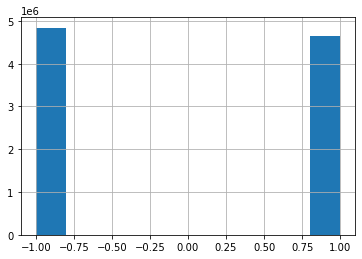

In [21]:
df.query("decay_id==0")["Polarity"].hist()

In [ ]:
df.hist2d()

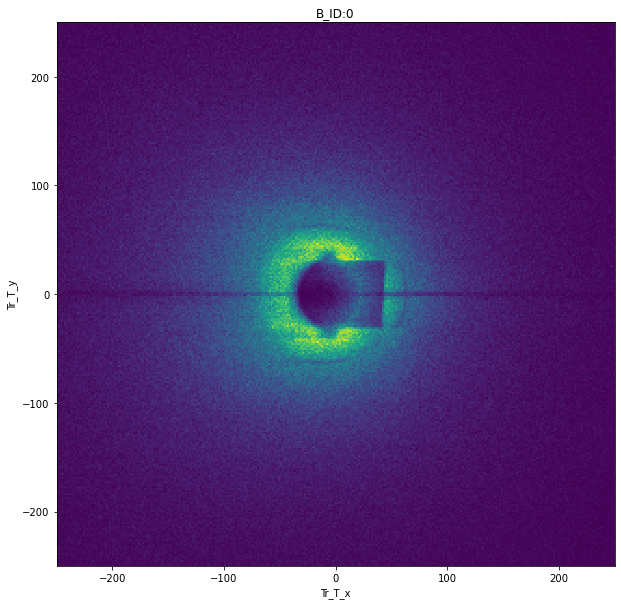

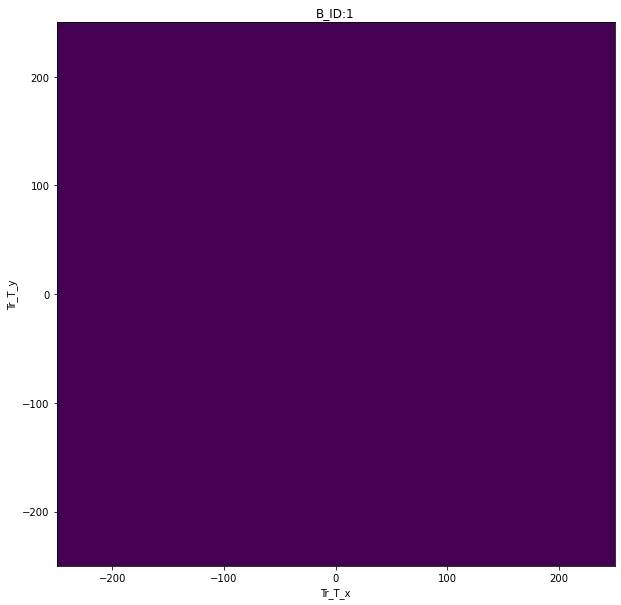

In [25]:
for B_is_strange in [0,1]:
    df_cut = df.query(f"(Tr_T_Charge==1)&(Polarity==1)&(decay_id=={B_is_strange})")
    
    plt.figure(figsize=(10,10))
    plt.title(f"B_ID:{B_is_strange}")
    plt.hist2d(df_cut["Tr_T_x"], df_cut["Tr_T_y"], range=[[-250,250],[-250,250]], bins=300)
    plt.xlabel("Tr_T_x")
    plt.ylabel("Tr_T_y")

    plt.show()

In [ ]:
df.plot.

# Check for the peak in Tr_p_proj on Bd SS tracks

In [4]:
features_to_load = ["B_PX", "B_PY", "B_PZ", "B_PE", 
                    "Tr_T_PX", "Tr_T_PY", "Tr_T_PZ", "Tr_T_E",
                    "B_TRUEID", "Tr_ORIG_FLAGS",
                    "Tr_MC_ID", "Tr_MC_MOTHER_ID"]

df = load_and_merge_from_root(input_files, input_file_keys, features_to_load, 1000000000)

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Entries in the data: 215860
Entries to be loaded: 215860


Load Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Entries in the data: 1199342
Entries to be loaded: 215860


Load Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [5]:
df["Tr_is_SS"] = (df["Tr_ORIG_FLAGS"] == 1).astype(int)
assert set(df["B_TRUEID"].unique()) == set([511,-511,531,-531]), "There are other signal particles than B0 and Bs"
df["B_is_strange"] = (np.abs(df["B_TRUEID"]) == 531).astype(int)

PX_proj = -1 * df[f"B_PX"] * df[f"Tr_T_PX"]
PY_proj = -1 * df[f"B_PY"] * df[f"Tr_T_PY"]
PZ_proj = -1 * df[f"B_PZ"] * df[f"Tr_T_PZ"]
PE_proj = +1 * df[f"B_PE"] * df[f"Tr_T_E"]

df["Tr_p_proj"] = np.sum([PX_proj, PY_proj, PZ_proj, PE_proj], axis=0)
df["log10_Tr_p_proj"] = np.log10(df["Tr_p_proj"])

In [6]:
df_ss = df.query("Tr_is_SS == 1")

### Tr_p_proj by Tr_MC_ID

In [7]:
x = []
y = []
uniq_mc_id, counts_mc_id = np.unique(df_ss["Tr_MC_ID"], return_counts=True)
sort_mask = np.argsort(-counts_mc_id)
uniq_mc_id = uniq_mc_id[sort_mask]
for mc_id in uniq_mc_id:
    df_mc_id = df_ss.query(f"Tr_MC_ID == {mc_id}")
    
    x.append(df_mc_id.query("B_is_strange == 0")["log10_Tr_p_proj"])
    y.append(df_mc_id.query("B_is_strange == 1")["log10_Tr_p_proj"])

In [8]:
from particle import Particle
particles = []
for mc_id in tqdm(uniq_mc_id):
    try:
        p = Particle.from_pdgid(mc_id)
        particles.append(p.name)
    except particle.ParticleNotFound as ex:
        particles.append(mc_id)

  0%|          | 0/22 [00:00<?, ?it/s]

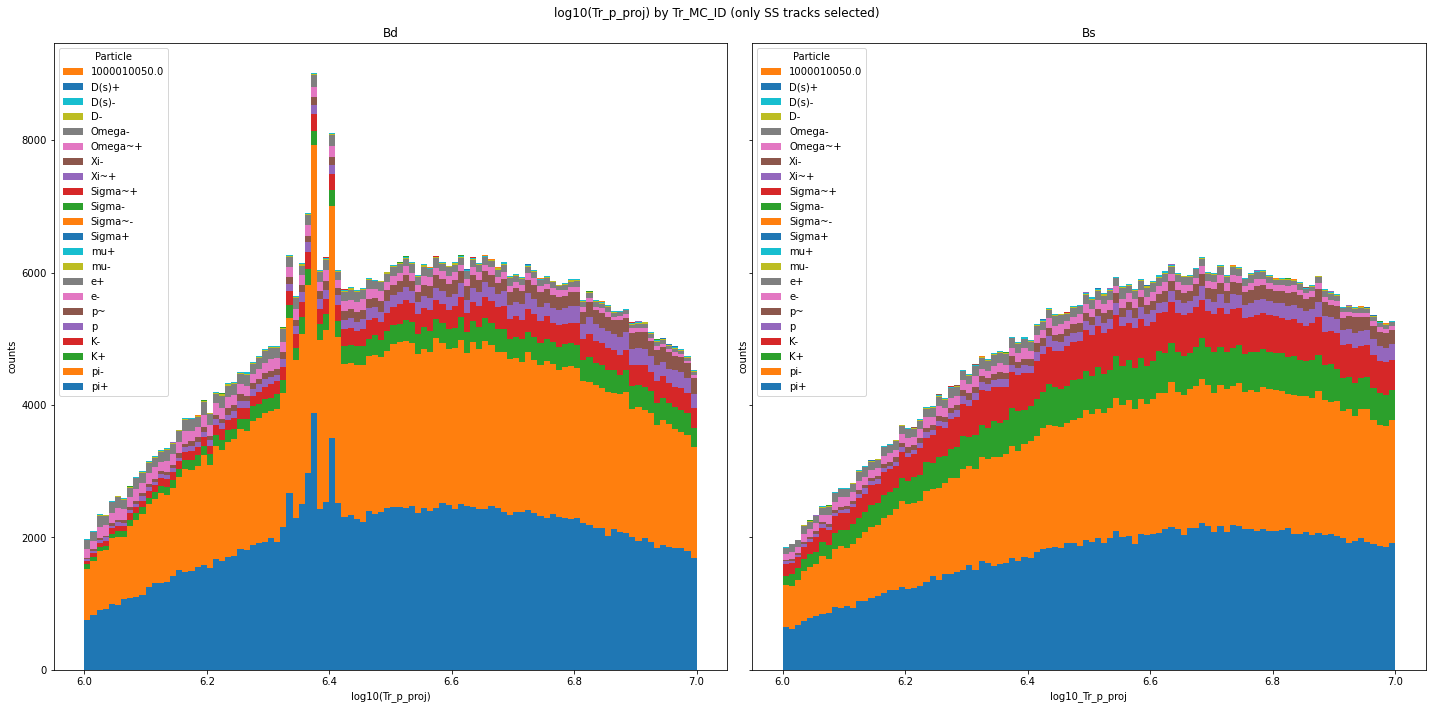

In [9]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle("log10(Tr_p_proj) by Tr_MC_ID (only SS tracks selected)")

axs[0].hist(x,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[0].set_title("Bd")
axs[0].set_ylabel("counts")
axs[0].set_xlabel("log10(Tr_p_proj)")

axs[1].hist(y,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[1].set_title("Bs")
axs[1].set_ylabel("counts")
axs[1].set_xlabel("log10_Tr_p_proj")

# reversed legend
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')

plt.tight_layout()
plt.show()

### Tr_p_proj by Tr_MC_MOTHER_ID

In [10]:
x = []
y = []
uniq_mc_id, counts_mc_id = np.unique(df_ss["Tr_MC_MOTHER_ID"], return_counts=True)
sort_mask = np.argsort(-counts_mc_id)
uniq_mc_id = uniq_mc_id[sort_mask]
for mc_id in tqdm(uniq_mc_id):
    df_mc_id = df_ss.query(f"Tr_MC_MOTHER_ID == {mc_id}")
    
    x.append(df_mc_id.query("B_is_strange == 0")["log10_Tr_p_proj"])
    y.append(df_mc_id.query("B_is_strange == 1")["log10_Tr_p_proj"])

  0%|          | 0/206 [00:00<?, ?it/s]

In [11]:
from particle import Particle
particles = []
for mc_id in uniq_mc_id:
    try:
        p = Particle.from_pdgid(mc_id)
        particles.append(p.name)
    except particle.ParticleNotFound as ex:
        particles.append(mc_id)

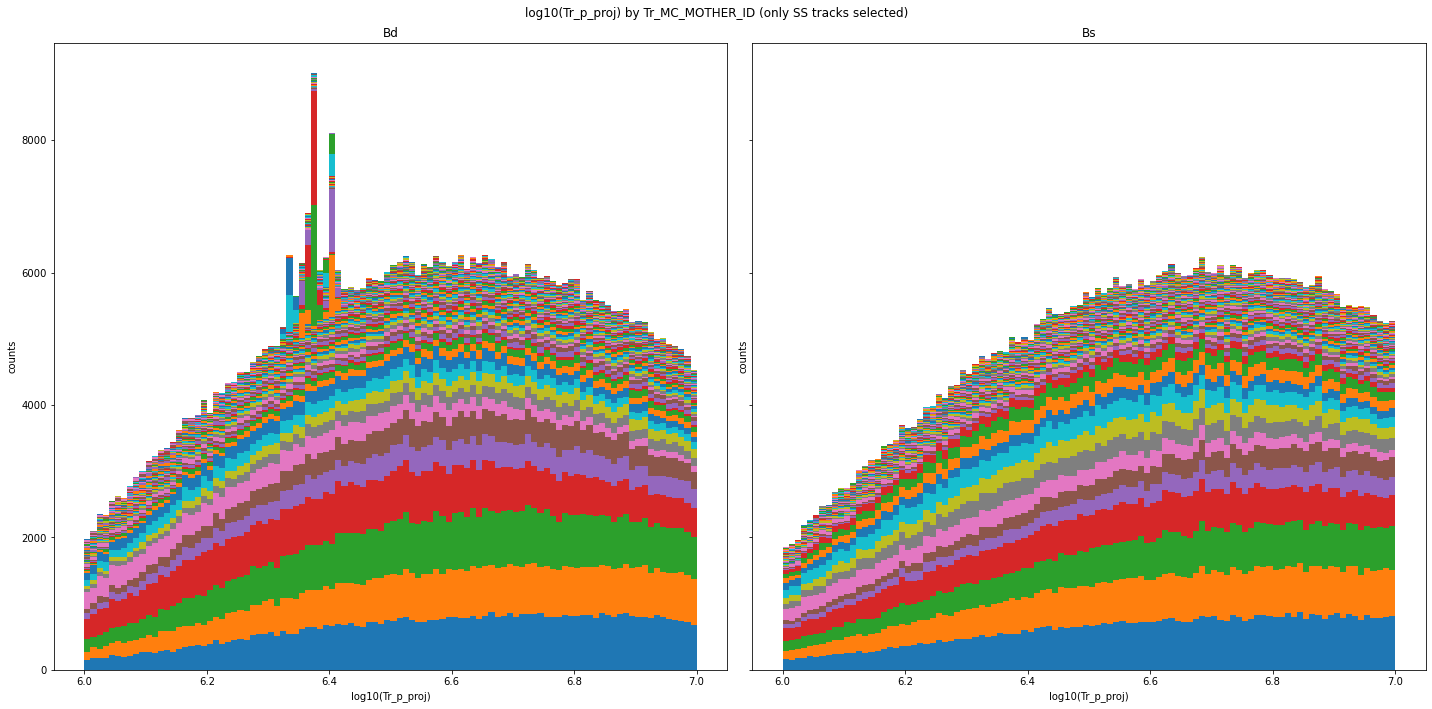

In [12]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle("log10(Tr_p_proj) by Tr_MC_MOTHER_ID (only SS tracks selected)")

axs[0].hist(x,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[0].set_title("Bd")
axs[0].set_ylabel("counts")
axs[0].set_xlabel("log10(Tr_p_proj)")

axs[1].hist(y,bins=100,range=(6.0,7.0), stacked=True, label=particles)
axs[1].set_title("Bs")
axs[1].set_ylabel("counts")
axs[1].set_xlabel("log10(Tr_p_proj)")

# reversed legend
#handles, labels = axs[0].get_legend_handles_labels()
#axs[0].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')
#
#handles, labels = axs[1].get_legend_handles_labels()
#axs[1].legend(handles[::-1], labels[::-1], title='Particle', loc='upper left')

plt.tight_layout()
plt.show()

### Tr_p_proj by Tr_MC_MOTHER_ID zoomed in to see what are the resonances

In [13]:
log10p_min = 6.32
log10p_max = 6.42

temp_df = df_ss.query(f"{log10p_min} <= log10_Tr_p_proj <= {log10p_max}")

x = []
y = []
uniq_mc_id, counts_mc_id = np.unique(temp_df["Tr_MC_MOTHER_ID"], return_counts=True)
sort_mask = np.argsort(-counts_mc_id)
uniq_mc_id = uniq_mc_id[sort_mask]
for mc_id in tqdm(uniq_mc_id):
    df_mc_id = temp_df.query(f"Tr_MC_MOTHER_ID == {mc_id}")
    
    x.append(df_mc_id.query("B_is_strange == 0")["log10_Tr_p_proj"])
    y.append(df_mc_id.query("B_is_strange == 1")["log10_Tr_p_proj"])

  0%|          | 0/153 [00:00<?, ?it/s]

In [14]:
# sort by the difference in max to min bin counts
x_hists = []
x_hist_diffs = []
for xi in x:
    x_hist, bin_edges = np.histogram(xi, bins=100, range=(log10p_min,log10p_max))
    x_hists.append(x_hist)
    
    x_hist_diff = np.max(x_hist) - np.min(x_hist)
    x_hist_diffs.append(x_hist_diff)
    
x_hist_diffs = np.array(x_hist_diffs)    
sort_mask = np.argsort(-x_hist_diffs)

uniq_mc_id = uniq_mc_id[sort_mask]
x = [x[i] for i in sort_mask]
y = [y[i] for i in sort_mask]

In [15]:
from particle import Particle
particles = []
for mc_id in uniq_mc_id:
    try:
        p = Particle.from_pdgid(mc_id)
        particles.append(p.name)
    except particle.ParticleNotFound as ex:
        particles.append(mc_id)

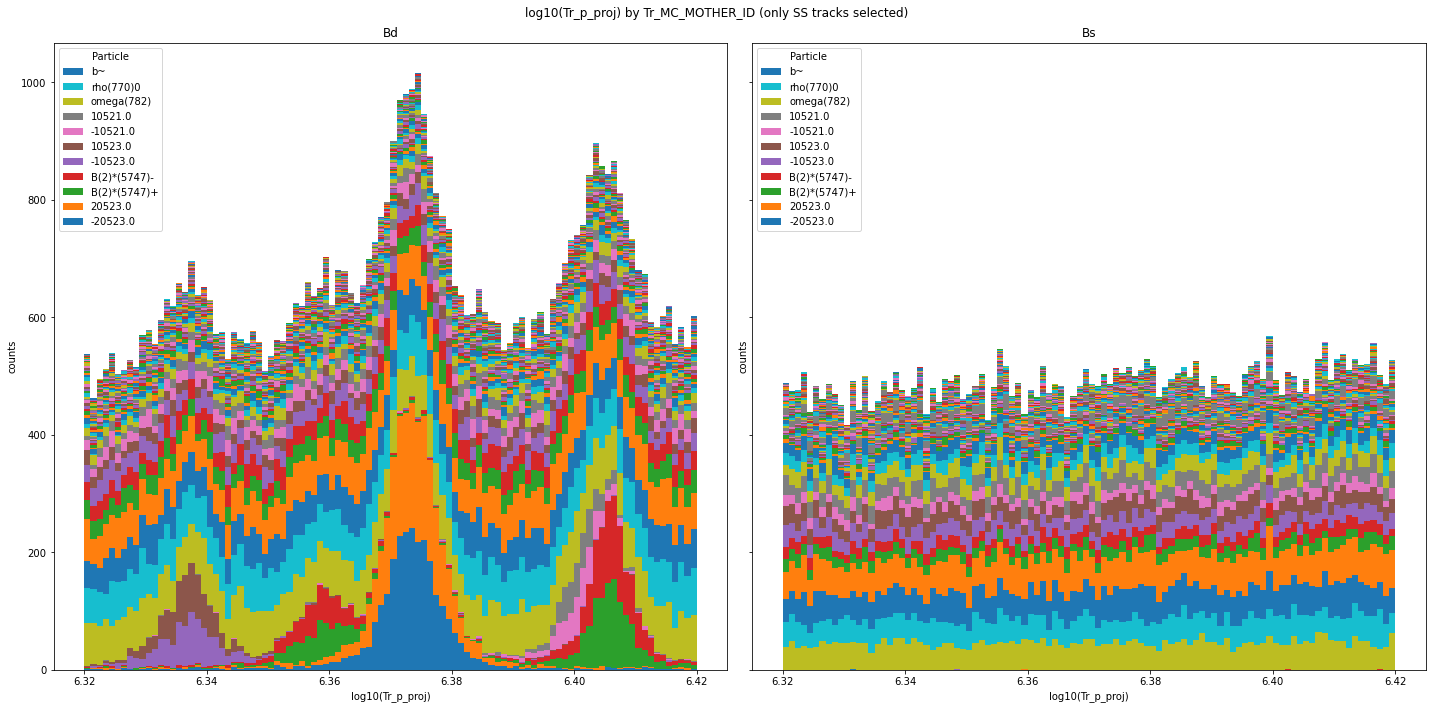

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,10), sharey=True, sharex=True)
fig.suptitle("log10(Tr_p_proj) by Tr_MC_MOTHER_ID (only SS tracks selected)")

axs[0].hist(x,bins=100,range=(log10p_min,log10p_max), stacked=True, label=particles)
axs[0].set_title("Bd")
axs[0].set_ylabel("counts")
axs[0].set_xlabel("log10(Tr_p_proj)")

axs[1].hist(y,bins=100,range=(log10p_min,log10p_max), stacked=True, label=particles)
axs[1].set_title("Bs")
axs[1].set_ylabel("counts")
axs[1].set_xlabel("log10(Tr_p_proj)")

# reversed legend
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[10::-1], labels[10::-1], title='Particle', loc='upper left')

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles[10::-1], labels[10::-1], title='Particle', loc='upper left')

plt.tight_layout()
plt.show()

# Check for correlation to the B mass

In [4]:
features_to_load = load_feature_keys(["direct"]) + ["B_M"]

df = load_and_merge_from_root(input_files, input_file_keys, features_to_load)

Datasets:   0%|          | 0/2 [00:00<?, ?it/s]

215860.0
Entries in the data: 215860
Entries to be loaded: 215860.0


Load Batches:   0%|          | 0/5 [00:00<?, ?it/s]

215860.0
Entries in the data: 1199342
Entries to be loaded: 1199342.0


Load Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [5]:
feature_keys = load_feature_keys(["direct"])
label_key = "B_M"


# Read in the feature properties
fprops = load_feature_properties()

In [6]:
# %%
# Apply cuts to the data
lower_quantile = 0.0001
higher_quantile = 0.9999

cut_loss = {}

mask = True
for feature in tqdm(feature_keys, desc="Apply Feature Cuts"):
    if fprops[feature]["feature_type"] == "numerical":
        temp_mask = fprops[feature][f"quantile_{lower_quantile}"] <= df[feature]
        temp_mask &= df[feature] <= fprops[feature][f"quantile_{higher_quantile}"]
        
        # include the error value because else, to much tracks get lost
        if "error_value" in fprops[feature].keys():
            temp_mask |= df[feature] == fprops[feature]["error_value"]
        
        cut_loss[feature] = {}
        cut_loss[feature]["relative_loss"] = (~temp_mask).sum()/len(temp_mask)
        cut_loss[feature]["absolute_loss"] = (~temp_mask).sum()
        
        mask &= temp_mask
        
df_data_cut = df[mask]

Apply Feature Cuts:   0%|          | 0/66 [00:00<?, ?it/s]

In [7]:
# %%
# Rearrange the features so that categorical features come last
numerical_features = [feature for feature in feature_keys if fprops[feature]["feature_type"] == "numerical"]
categorical_features = [feature for feature in feature_keys if fprops[feature]["feature_type"] == "categorical"]

feature_keys = numerical_features + categorical_features

In [8]:
# %% 
# Calculate the correlation matrix
print("Calculating the correlation matrix...")
df_corr = df_data_cut[feature_keys+[label_key]].corr()
print("Done calculating the correlation matrix.")

Calculating the correlation matrix...
Done calculating the correlation matrix.


In [13]:
df_corr[f"abs_{label_key}"] = np.abs(df_corr[label_key])

df_corr.sort_values(by=f"abs_{label_key}", ascending=False, inplace=True)

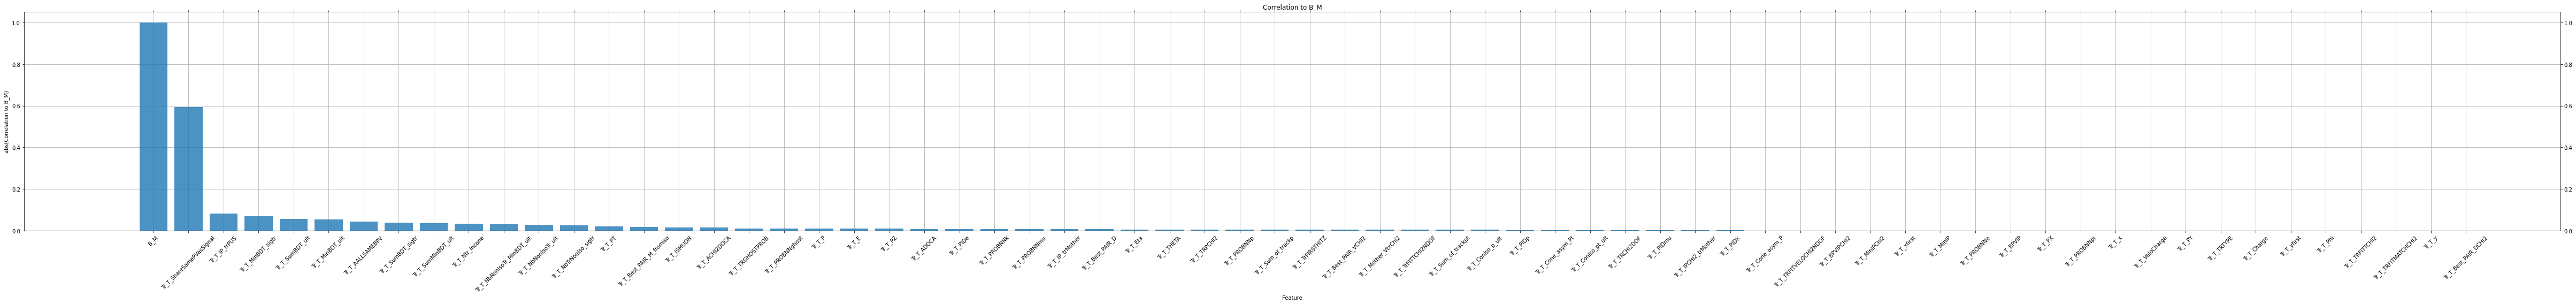

In [14]:
# Plot the correlation to B_M
fig, ax = plt.subplots(1,1, figsize=(len(features_to_load)*1, 8))

#fig.suptitle(f"Feature Importance")

ax.set_title(f"Correlation to {label_key}")

ax.bar(df_corr.index, np.abs(df_corr.loc[:,label_key]), alpha=0.8, zorder=3)

ax.set_xlabel("Feature")
ax.set_ylabel(f"abs(Correlation to {label_key})")

ax.tick_params(axis="y", left=True, right=True, labelleft=True, labelright=True)
ax.tick_params(axis="x", bottom=True, top=True, rotation=45)
ax.grid(zorder=0)

plt.tight_layout()
plt.savefig(paths.plots_dir/f"corr_to_{label_key}.pdf")
plt.show()